In [95]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras import backend as K
from keras.models import Model
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
from IDNNs.idnns.information.information_process import get_information
from IDNNs.idnns.plots.plot_figures import plot_all_epochs, extract_array
from joblib import dump


In [2]:

AES_Sbox = np.array(
    [0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76, 0xCA, 0x82, 0xC9,
     0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0, 0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F,
     0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15, 0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07,
     0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75, 0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3,
     0x29, 0xE3, 0x2F, 0x84, 0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58,
     0xCF, 0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8, 0x51, 0xA3,
     0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2, 0xCD, 0x0C, 0x13, 0xEC, 0x5F,
     0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73, 0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88,
     0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB, 0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC,
     0x62, 0x91, 0x95, 0xE4, 0x79, 0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A,
     0xAE, 0x08, 0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A, 0x70,
     0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E, 0xE1, 0xF8, 0x98, 0x11,
     0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF, 0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42,
     0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16])

hw = np.array([bin(x).count("1") for x in range(256)])


def load_traces(database_file, start_at=1, number_samples=0, max_rows=int(1e6)):
    # Power Consumption Start_at -> Start_at + Number_Samples
    traces = np.loadtxt(database_file, delimiter=',', dtype=np.float64, skiprows=1,
                        usecols=range(start_at, start_at + number_samples), max_rows=max_rows)
    # Plaintext Start_at - 1
    inputoutput = np.loadtxt(database_file, delimiter=',', dtype=np.str, skiprows=1,
                             usecols=start_at - 1, max_rows=max_rows)
    # Chiphertext Start_at + Number_Samples
    # Key Start_at + Number_Samples + 1
    key = np.loadtxt(database_file, delimiter=',', dtype=np.str, skiprows=1,
                     usecols=start_at + number_samples + 1, max_rows=max_rows)
    # print("traces shape: {}\ninputoutput shape: {}\n".format(traces.shape, inputoutput.shape))
    return traces, inputoutput, key


def statcorrect_traces(dataset):
    if len(dataset) == 3:
        traces, inputoutput, key = dataset
    elif len(dataset) == 4:
        traces, inputoutput, key, labels = dataset

    # traces_statcorrect = (traces - np.mean(traces, axis=1).reshape(-1,1))/np.std(traces, axis=1).reshape(-1,1)
    traces_statcorrect = (traces - np.mean(traces, axis=0).reshape(1, -1)) / np.std(traces, axis=0).reshape(1, -1)

    if len(dataset) == 3:
        return traces_statcorrect, inputoutput, key
    elif len(dataset) == 4:
        return traces_statcorrect, inputoutput, key, labels


def shorten_traces(dataset, start_at=0, number_samples=0):
    if len(dataset) == 3:
        traces, inputoutput, key = dataset
    elif len(dataset) == 4:
        traces, inputoutput, key, labels = dataset
        labels_selected = labels[start_at:start_at + number_samples]

    traces_selected = traces[start_at:start_at + number_samples]
    inputoutput_selected = inputoutput[start_at:start_at + number_samples]
    key_selected = key[start_at:start_at + number_samples]

    if len(dataset) == 3:
        return traces_selected, inputoutput_selected, key_selected
    elif len(dataset) == 4:
        return traces_selected, inputoutput_selected, key_selected, labels_selected


def create_labels_sboxinputkey(dataset, database_file, col):
    if len(dataset) == 3:
        traces, inputoutput, key = dataset
    else:
        traces, inputoutput, key, _ = dataset

    labels = np.loadtxt(database_file, delimiter=',', dtype=np.float, skiprows=1,
                        usecols=col, max_rows=traces.shape[0]).astype(np.int)

    return traces, inputoutput, key, labels


def plot_loss_acc(loss, acc, dir):
    print("Plotting Loss and Accuracy...")
    fig = plt.figure(4)
    ax = plt.subplot(111)
    ax.plot(loss, label='Loss')
    plt.title("Network Loss")
    ax.legend()
    plt.savefig('{}loss.png'.format(dir), dpi=500, format='png')
    plt.figure(5)
    plt.plot(acc, label='Network Accuracy')
    plt.legend()
    plt.savefig('{}accuracy.png'.format(dir), dpi=500, format='png')


def plot_weights_ave_std(ave, std, importantEpoch, dir):
    print("Plotting Standardized Weights...")
    plt.figure(3)
    ave = np.transpose(ave)
    std = np.transpose(std)
    for i, a in enumerate(ave):
        a = a / np.linalg.norm(a)
        plt.plot(importantEpoch, a, label='Ave Layer{}'.format(i))
    for i, s in enumerate(std):
        s = s / np.linalg.norm(s)
        plt.plot(importantEpoch, s, '--', label='Std Layer{}'.format(i))

    # plt.xticks(importantEpoch)
    plt.legend()
    plt.savefig('{}networkWeights.png'.format(dir), dpi=500, format='png')


def key_rank(model, inout_test, traces_test, kByte, trueKey):
    p = model.predict(traces_test)
    rank = np.zeros(inout_test.shape[0])
    prob_vector = np.zeros(256)

    for i, v in enumerate(inout_test):
        for kh in range(0, 256):
            hemw = hw[AES_Sbox[bytes.fromhex(v)[kByte] ^ kh]]
            prob_vector[kh] += p[i][hemw]
        df = pd.DataFrame({'prob': prob_vector})
        df = df.sort_values(['prob'], ascending=False)
        df = df.reset_index()
        df.rename(columns={'index': 'keyH'}, inplace=True)
        rank[i] = df[df.keyH == int(trueKey, 16)].index.tolist()[0]
    return rank


def plot_key_rank(keypred, byte, file_name, traces):
    # Graph rank of correct key for one byte
    print("Plotting Key Rank...")
    plt.figure(1)
    plt.plot(keypred.index.values, keypred[0], label='key{}'.format(byte))
    plt.xlabel('# of traces')
    plt.ylabel('Rank')
    plt.xticks(np.arange(0, traces+1, step=traces/10))
    plt.legend()
    plt.title("CNN")
    plt.savefig('{}{}({}).png'.format(file_name, byte, key[0][2 * byte:2 * byte + 2]), dpi=500, format='png')


def _evaluate(modl: Model, nodes_to_evaluate, x, y=None):
    symb_inputs = (modl._feed_inputs + modl._feed_targets + modl._feed_sample_weights)
    f = K.function(symb_inputs, nodes_to_evaluate)
    x_, y_, sample_weight_ = modl._standardize_user_data(x, y)
    return f(x_ + y_ + sample_weight_)


def get_activations(model, x, y, layer_name=None):
    nodes = [layer.output for layer in model.layers if layer.name == layer_name or layer_name is None]
    # we process the placeholders later (Inputs node in Keras). Because there's a bug in Tensorflow.
    input_layer_outputs, layer_outputs = [], []
    [input_layer_outputs.append(node) if 'input_' in node.name else layer_outputs.append(node) for node in nodes]
    activations = _evaluate(model, layer_outputs, x, y)
    return activations


def plot_mut(mut, important_epoch, file_name, epochFlag):
    print("Plotting Mutual Info...")
    I_XT_array = np.array(extract_array(mut, 'local_IXT'))
    x_ticks = np.arange(0, np.around(I_XT_array.max()) + 1, 1)
    I_TY_array = np.array(extract_array(mut, 'local_ITY'))
    y_ticks = np.arange(0, np.around(I_TY_array.max() + .1, decimals=1), .2)
    font_size = 34
    axis_font = 28
    bar_font = 28
    colorbar_axis = [0.905, 0.12, 0.03, 0.82]
    f, (axes) = plt.subplots(1, 1, sharey=True, figsize=(14, 10))
    f.subplots_adjust(left=0.097, bottom=0.12, right=.87, top=0.99, wspace=0.03, hspace=0.03)
    plot_all_epochs(I_XT_array, I_TY_array, axes, important_epoch, f, 0, 0, I_XT_array.shape[0], font_size, y_ticks,
                    x_ticks, colorbar_axis, "Mutual Info", axis_font, bar_font, file_name, epochFlag)


# use for hamming weight leakage model
def create_model_cnn(architecture, classes=9, number_samples=200):
    input_shape = (number_samples, 1)
    trace_input = Input(shape=input_shape)
    dense_layers = len(architecture)-1
    first = True
    for i, a in enumerate(architecture):
        if i != dense_layers:
            for j, c in enumerate(a):
                if first:
                    x = Conv1D(filters=c, kernel_size=3, strides=3, activation='relu', padding='valid',
                               name='block{}_conv{}'.format(i,j))(trace_input)
                    first = False
                else:
                    x = Conv1D(filters=c, kernel_size=3, strides=3, activation='relu', padding='valid',
                               name='block{}_conv{}'.format(i,j))(x)
            x = MaxPooling1D(pool_size=2, strides=2, padding='same', name='block{}_pool'.format(i))(x)
    x = Flatten(name='flatten')(x)
    for i, a in enumerate(architecture[dense_layers]):
        x = Dense(a, activation='tanh', name='fc{}'.format(i))(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    model = Model(trace_input, x, name='cnn')
    # optimizer = SGD(lr=0.001, decay=0, momentum=0.9, nesterov=True)
    optimizer = Adam(lr=0.0004, decay=0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# 4 Dense Layers with Adam optimizer MLP
def create_model_mlp(architecture, classes=9, number_samples=200):
    input_shape = (number_samples, 1)
    trace_input = Input(shape=input_shape)
    x = Flatten(name='flatten')(trace_input)
    for i, a in enumerate(architecture):
        x = Dense(a, activation='tanh', name='fc{}'.format(i))(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    model = Model(trace_input, x, name='mlp_sgd')
    # optimizer = SGD(lr=0.001, decay=0, momentum=0.9, nesterov=True)
    optimizer = Adam(lr=0.0004, decay=0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# 1 Conv 2 Dense Layers with RMSprop optimizer - CnnBest Benadjila et al.
def create_model_ascad(classes=9, number_samples=200):
    input_shape = (number_samples, 1)
    trace_input = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=10, strides=10, activation='relu', padding='same', name='block1_conv1')(
        trace_input)
    x = AveragePooling1D(pool_size=2, strides=2, padding='same', name='block1_pool')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='tanh', name='fc1')(x)
    x = Dense(4096, activation='tanh', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    model = Model(trace_input, x, name='cnn_RMSprop')
    optimizer = RMSprop(lr=0.00001, decay=0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model



In [92]:
n = 'mlp'
a = [64,32,16]
e = 50
ms = 20
ts = 10000
vs = 2000
# key to attack
k = 0
# repetitions - train the network
r = 5
rl = False

out_dir = '{}/net:{}_{}_epoch:{}_trainingSize:{}/'.format(os.getcwd(), n, a, e, ts)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
trainset = 'datasets/SmartCardAES/AES_trainset.csv'
# trainset = 'datasets/SmartCardAES/AES_trainset_sim.csv'
# trainset = '/home/nfs/mpop/Documents/SmartCardAES/AES_trainset.csv'
testset = 'datasets/SmartCardAES/AES_testset.csv'
# testset = 'datasets/SmartCardAES/AES_testset_sim.csv'
# testset = '/home/nfs/mpop/Documents/SmartCardAES/AES_testset.csv'
if 'dataset' not in locals():
    dataset = load_traces(trainset, 1, 1654, ts)
    # dataset = load_traces(trainset, 1, 16, 10000)
    dataset = statcorrect_traces(dataset)
    dataset_test = load_traces(testset, 1, 1654, vs)
    # dataset_test = load_traces(testset, 1, 16, 2000)
    dataset_test = statcorrect_traces(dataset_test)
    # key_prediction = np.zeros(shape=(16, min(dataset_test[1].shape[0], dataset[1].shape[0])))

mut = []
for r_nr in range(r):
    dataset_keyh = create_labels_sboxinputkey(dataset, trainset, 1657 + k)  # Template - Use known SubKey byte
    # dataset_keyh = create_labels_sboxinputkey(dataset, trainset, 19 + k)  # Template - Use known SubKey byte
    dataset_test_core = create_labels_sboxinputkey(dataset_test, testset, 1657 + k)
    # dataset_test_core = create_labels_sboxinputkey(dataset_test, testset, 19 + k)
    traces_train, inputoutput_train, _, labels_train = dataset_keyh
    traces_test, inputoutput_test, key, labels_test = dataset_test_core
    print("<------------------Attacking Byte: {} Iteration: {}------------------>".format(k,r_nr))
    classes = 9
    if rl:
        labels_train = np.random.randint(classes, size=labels_train.shape[0])
    traces_train_reshaped = traces_train.reshape((traces_train.shape[0], traces_train.shape[1], 1))
    labels_train_categorical = to_categorical(labels_train, num_classes=classes)
    traces_test_reshaped = traces_test.reshape((traces_test.shape[0], traces_test.shape[1], 1))
    labels_test_categorical = to_categorical(labels_test, num_classes=classes)
    save_model = ModelCheckpoint(out_dir+'model_epoch{epoch}.h5', period=1000)
    class CalculateRecall(Callback):
        def __init__(self, data, labels, message_prefix=None):
            self.data = data
            self.labels = labels
            self.message_prefix = message_prefix + ' ' or ''
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            predictions = self.model.predict(self.data)
            correctly_classified = (np.argmax(predictions, axis=1) == self.labels)
            _sum = 0.
            for i in np.unique(self.labels):
                n_correct = len(np.nonzero(correctly_classified[np.where(self.labels == i)[0]])[0])
                n_total = len(np.where(self.labels == i)[0])
                _sum += n_correct / n_total
            recall = _sum / len(np.unique(self.labels))
            print(self.message_prefix + 'recall:', recall)
    class CalculateMut(Callback):
        def __init__(self, calcEpoch, x):
            self.calcEpoch = calcEpoch
            self.x = x
            self.idx = 0
            self.mut = []
        def on_epoch_end(self, epoch, logs=None):
            if epoch == self.calcEpoch[self.idx]:
                print("Getting Activations...")
                ws = get_activations(self.model, self.validation_data[0], self.validation_data[1])
                self.mut.append(
                    get_information(ws, self.x, self.validation_data[1], 30, 50, calc_parallel=True))
                if self.idx < len(self.calcEpoch) - 1:
                    self.idx += 1
    class CalculateLayerStat(Callback):
        def __init__(self, calcEpoch):
            self.ave = []
            self.std = []
            self.idx = 0
            self.calcEpoch = calcEpoch
        def on_epoch_end(self, epoch, logs=None):
            if epoch == self.calcEpoch[self.idx]:
                ave = np.zeros(len(self.model.layers))
                std = np.zeros(len(self.model.layers))
                for l, layer in enumerate(self.model.layers):
                    if 'fc' in layer.name or 'predictions' in layer.name:
                        w = layer.get_weights()
                        ave[l] = np.average(w[1])
                        std[l] = np.std(w[1])
                self.ave.append(ave)
                self.std.append(std)
                if self.idx < len(self.calcEpoch) - 1:
                    self.idx += 1
    class CalculateKeyRank(Callback):
        def __init__(self, calcEpoch, testTraces, inout_test, keyByte):
            self.idx = 0
            self.testTraces = testTraces
            self.inout_test = inout_test
            self.calcEpoch = calcEpoch
            self.keyByte = keyByte
            self.epochTraceRank = []
        def on_epoch_end(self, epoch, logs=None):
            if epoch == self.calcEpoch[self.idx]:
                # Choose random batch of test traces + inputData to calculate rank
                idx = np.random.randint(self.validation_data[0].shape[0], size=self.testTraces)
                p = self.model.predict(self.validation_data[0][idx, :])
                in_p = self.inout_test[idx]
                rank = np.zeros(in_p.shape[0])
                prob_vector = np.zeros(256)
                for i, v in enumerate(in_p):
                    for kh in range(0, 256):
                        hemw = hw[AES_Sbox[bytes.fromhex(v)[0] ^ kh]]
                        prob_vector[kh] += p[i][hemw]
                    df = pd.DataFrame({'prob': prob_vector})
                    df = df.sort_values(['prob'], ascending=False)
                    df = df.reset_index()
                    df.rename(columns={'index': 'keyH'}, inplace=True)
                    rank[i] = df[df.keyH == int(self.keyByte, 16)].index.tolist()[0]
                if rank[-1] > 0:
                    self.epochTraceRank.append(self.testTraces)
                else:
                    rev_rank = rank[::-1]
                    for i, v in enumerate(rev_rank):
                        if v > 0:
                            self.epochTraceRank.append(self.testTraces-i)
                            break
                if self.idx < len(self.calcEpoch) - 1:
                    self.idx += 1
    epoch_max = e
    num_of_samples = ms
    important_epoch = np.unique(
        np.logspace(np.log2(1), np.log2(epoch_max), num_of_samples, dtype=int, base=2)) - 1
    calculate_recall_train = CalculateRecall(traces_train_reshaped, labels_train, 'train')
    calculate_recall_test = CalculateRecall(traces_test_reshaped, labels_test, 'test')
    calculate_mut_test = CalculateMut(important_epoch, traces_test)
    calculate_layerStat = CalculateLayerStat(important_epoch)
    calculate_keyRaks = CalculateKeyRank(important_epoch, vs, inputoutput_test, key[0][2 * k: 2 * k + 2])
    callbacks = [calculate_recall_train, calculate_recall_test, save_model, calculate_mut_test,
                 calculate_layerStat, calculate_keyRaks]
    if n == 'cnn':
        print("Building CNN Network")
        model = create_model_cnn(a, classes=classes, number_samples=traces_train.shape[1])
    else:
        print("Building MLP Network")
        model = create_model_mlp(a, classes=classes, number_samples=traces_train.shape[1])
    history = model.fit(x=traces_train_reshaped,
                        y=labels_train_categorical,
                        batch_size=512,
                        verbose=0,
                        epochs=epoch_max,
                        validation_data=(traces_test_reshaped, labels_test_categorical),
                        callbacks=callbacks)

    print("Saving Trained Model...")
    model.save(out_dir + "model.h5")
    
    mut.append(callbacks[3].mut)

<------------------Attacking Byte: 0 Iteration: 0------------------>
Building MLP Network
train recall: 0.18592658479758184
test recall: 0.15061849533284283
Getting Activations...
Start calculating the information...
train recall: 0.2320932771301221
test recall: 0.17858699899493075
Getting Activations...
Start calculating the information...
train recall: 0.27119979443868475
test recall: 0.21123603289135273
Getting Activations...
Start calculating the information...
train recall: 0.2890856834976074
test recall: 0.2179084774456044
Getting Activations...
Start calculating the information...
train recall: 0.2944717118847801
test recall: 0.22496488923814992
Getting Activations...
Start calculating the information...
train recall: 0.30289956764553166
test recall: 0.22494633775550885
Getting Activations...
Start calculating the information...
train recall: 0.32163475564785826
test recall: 0.23722822749127348
Getting Activations...
Start calculating the information...
train recall: 0.335539264

Plotting Loss and Accuracy...
Saving Mutual Info Values...
Plotting Mutual Info...
Determining Correct Key Ranking...
Plotting Key Rank...
Saving Layer Weight Data...
Plotting Standardized Weights...
Plotting Mutual Info...


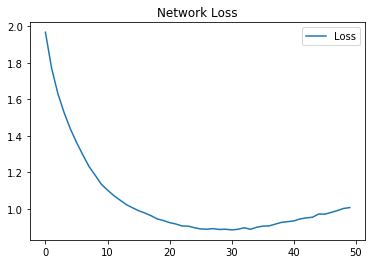

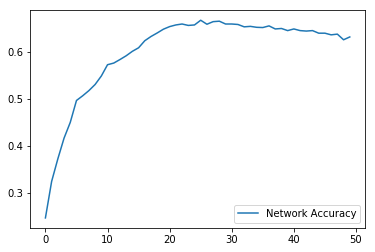

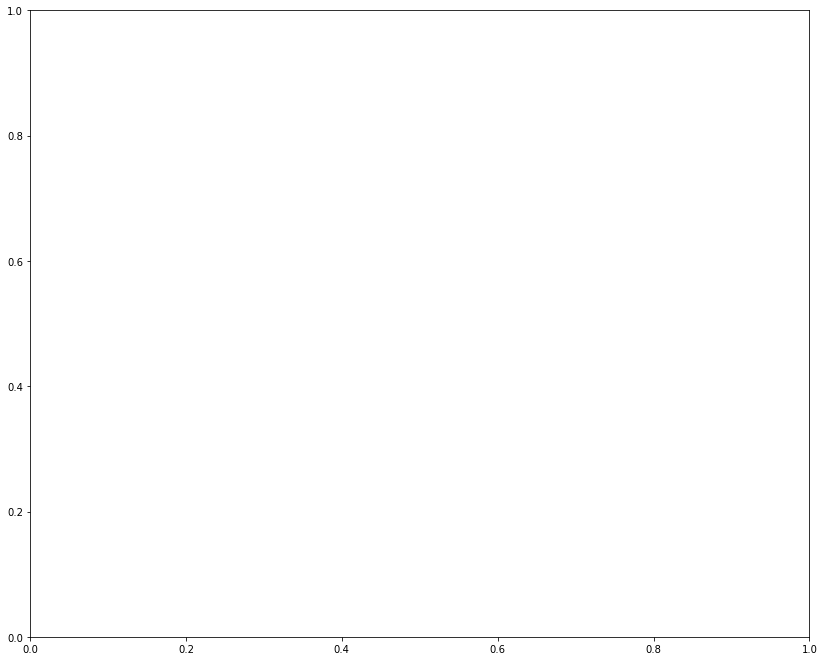

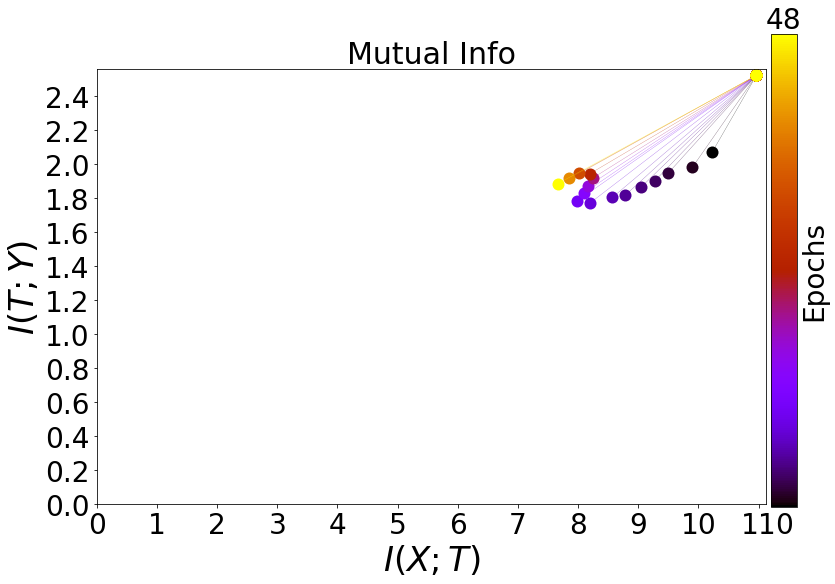

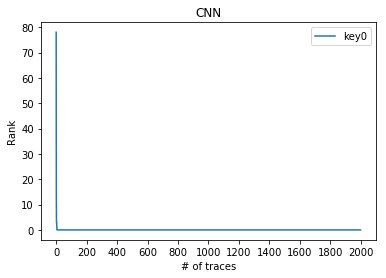

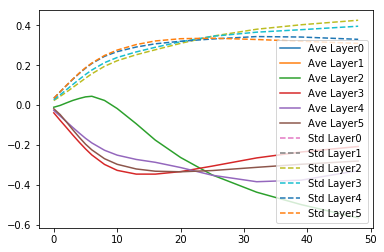

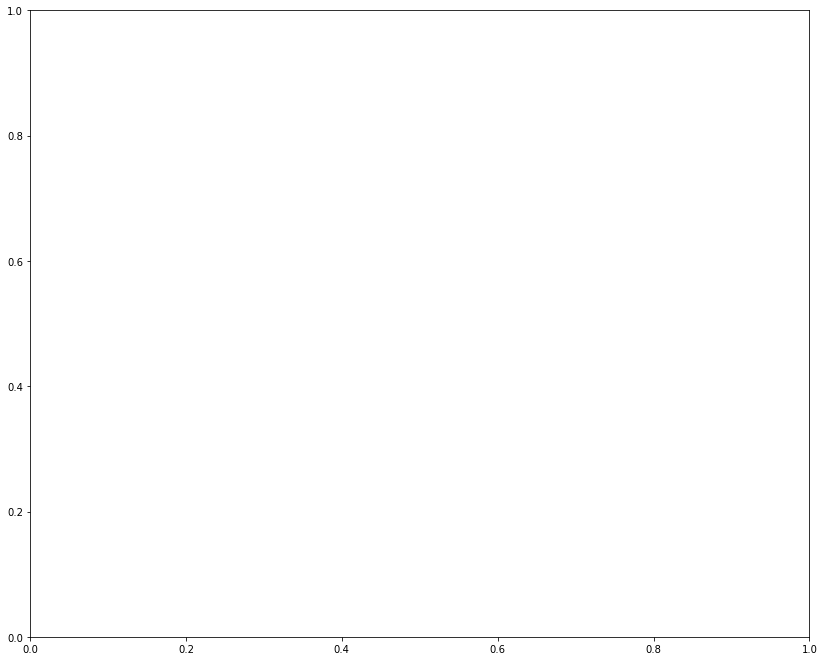

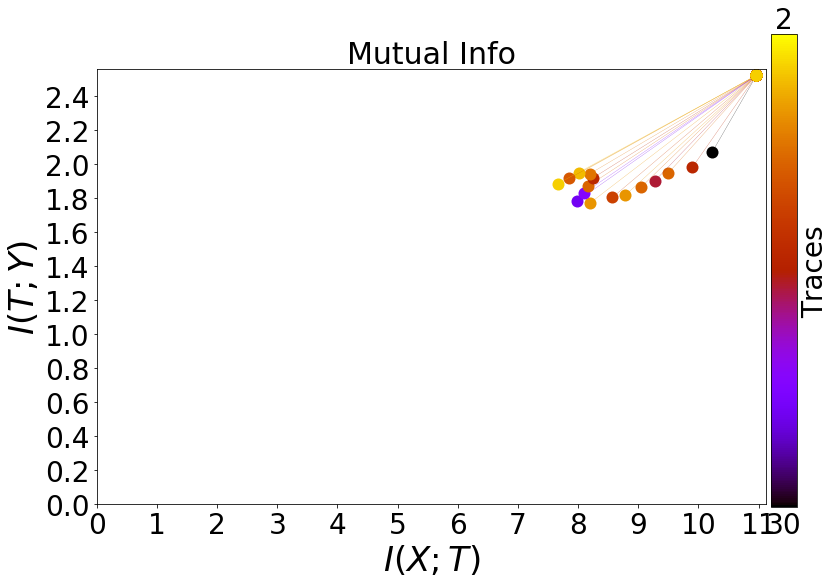

In [57]:
           
dump(history, out_dir + 'modelHistory.gz', compress=3)
plot_loss_acc(history.history['val_loss'], history.history['val_acc'], out_dir)
print("Saving Mutual Info Values...")
dump(callbacks[3].mut, out_dir + 'MutualInfoKey.gz', compress=3)
plot_mut(callbacks[3].mut, important_epoch, out_dir + 'mutualInfo', True)
print("Determining Correct Key Ranking...")
key_prediction = key_rank(model, inputoutput_test, traces_test_reshaped, k, key[0][2 * k:2 * k + 2])
plot_key_rank(pd.DataFrame(key_prediction), k, out_dir + 'keyRank', vs)
print("Saving Layer Weight Data...")
plot_weights_ave_std(callbacks[4].ave, callbacks[4].std, important_epoch, out_dir)
dump(callbacks[3], out_dir + 'weights.gz', compress=3)
plot_mut(callbacks[3].mut, callbacks[5].epochTraceRank, out_dir + 'mutualInfoRanks', False)


In [18]:
del model


Plotting Mutual Info...


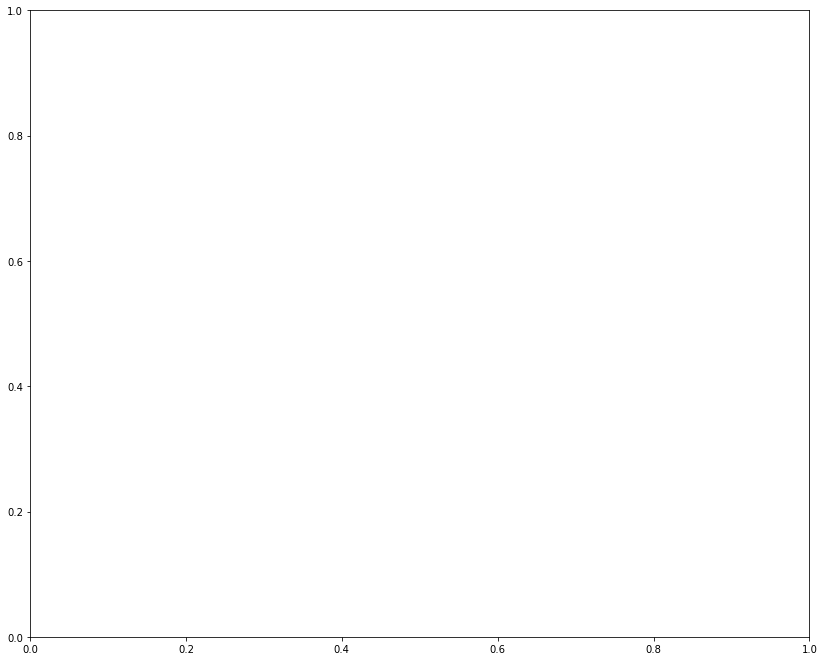

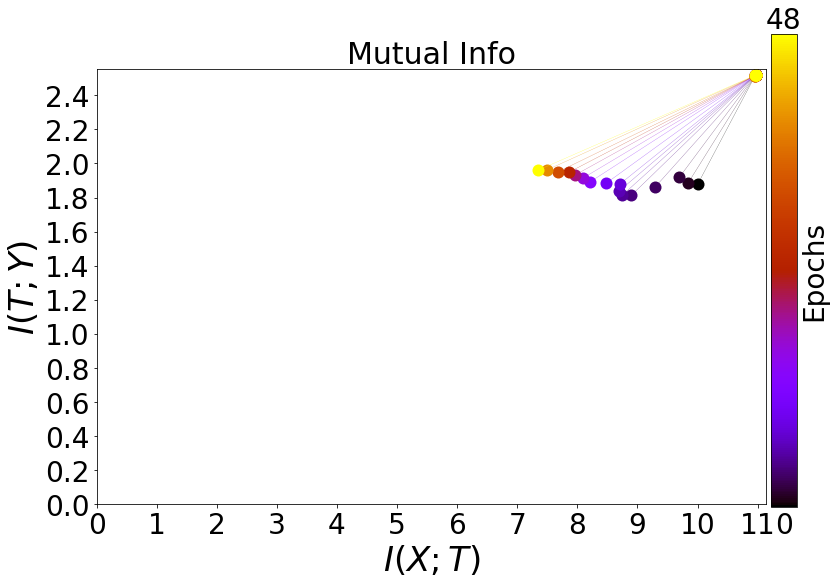

In [96]:

mut_ave = copy.deepcopy(mut[0])
for e in range(len(mut[0])):
    for i in range(len(mut[0][e])):
        ave_IXT = 0
        ave_ITY = 0
        for j in range(r):
            ave_IXT = ave_IXT + mut[j][e][i][0]['local_IXT']
            ave_ITY = ave_ITY + mut[j][e][i][0]['local_ITY']
        
        mut_ave[e][i][0]['local_IXT'] = ave_IXT/r
        mut_ave[e][i][0]['local_ITY'] = ave_ITY/r

plot_mut(mut_ave, important_epoch, out_dir + 'mutualInfo', True)

Plotting Mutual Info...
Plotting Mutual Info...


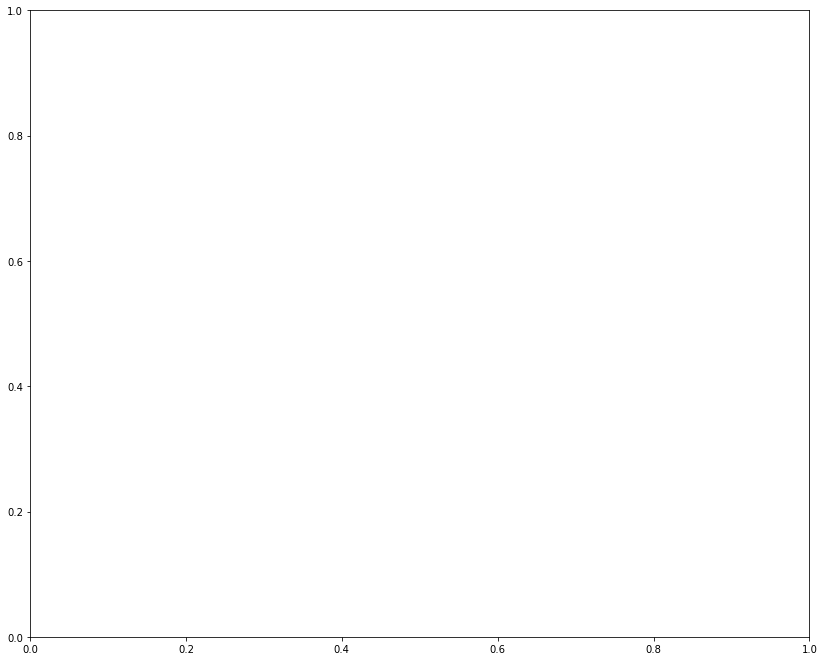

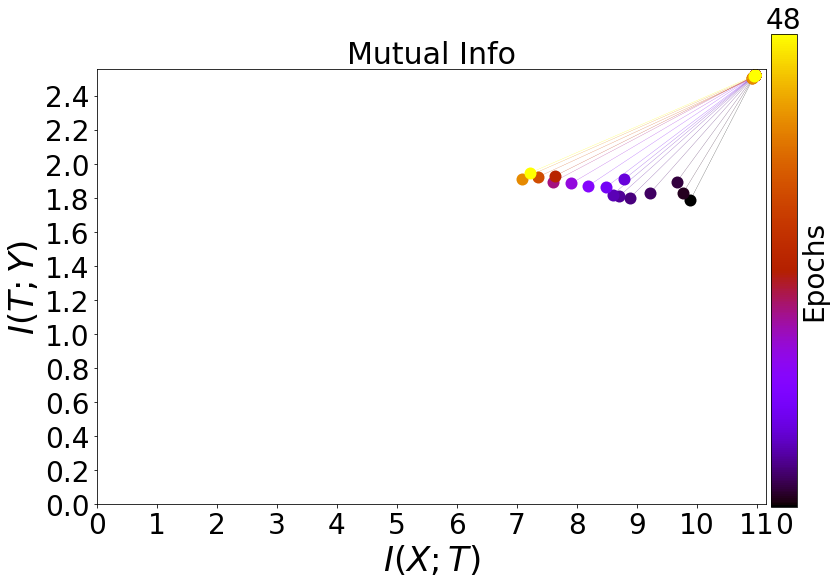

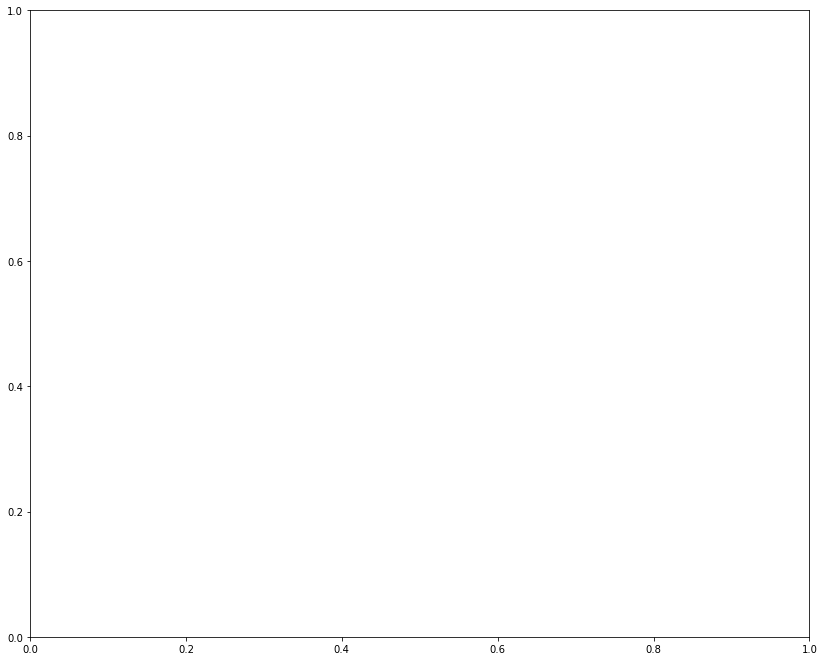

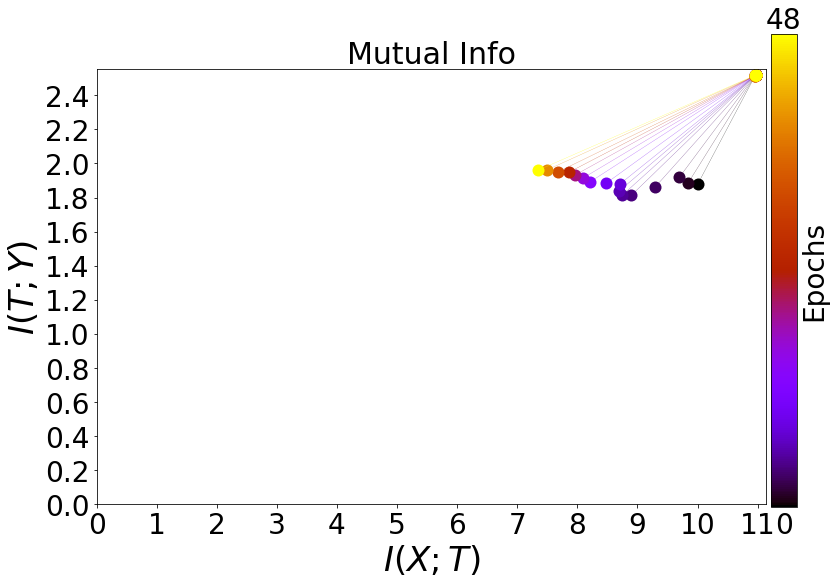